### **What is Time Series?**  
<img src='../Images/ts_image.png' style="float: left;margin:5px 20px 5px 1px" width='350' height='250'>

A time series is a collection of observations of well-defined data items obtained through repeated measurements over time. For example, measuring the value of air passengers each month of the year would comprise a time series.  
  
### **What are time series Metrics?**  
A time series is a sequence of sequential data points that occur over a particular interval of time. A “metric”, in this case, refers to the piece of data that is tracked at each increment of time.  

**Level:** The average value in the series  
**Trend:** Increases, decreases, or stays the same over time  
**Seasonal or Periodic:** Pattern repeats periodically over   
**Cyclical:** Pattern that increases and decreases but usually related to non-seasonal activity, like business cycles  
**Random or Irregular Variations:** Increases and decreases that don’t have any apparent pattern  
  
In this notebook we will use the air passengers data for time series analysis. I took the dataset from kaggle thanks to *SUMANTHVRAO*. You can find the dataset [here](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data).  
Also you can find the dataset on `../Datasets/DailyDelhiClimateTrain.csv` path.  

In [27]:
import pandas as pd 
import numpy as np 

df_path = '../Datasets/DailyDelhiClimateTrain.csv'
df = pd.read_csv(df_path)
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'meantemp']]
df.set_index('date', inplace=True)

df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


### **Decompose the Data**  
We can see compositions like (trend, seasonal etc.) with `statsmodels` library

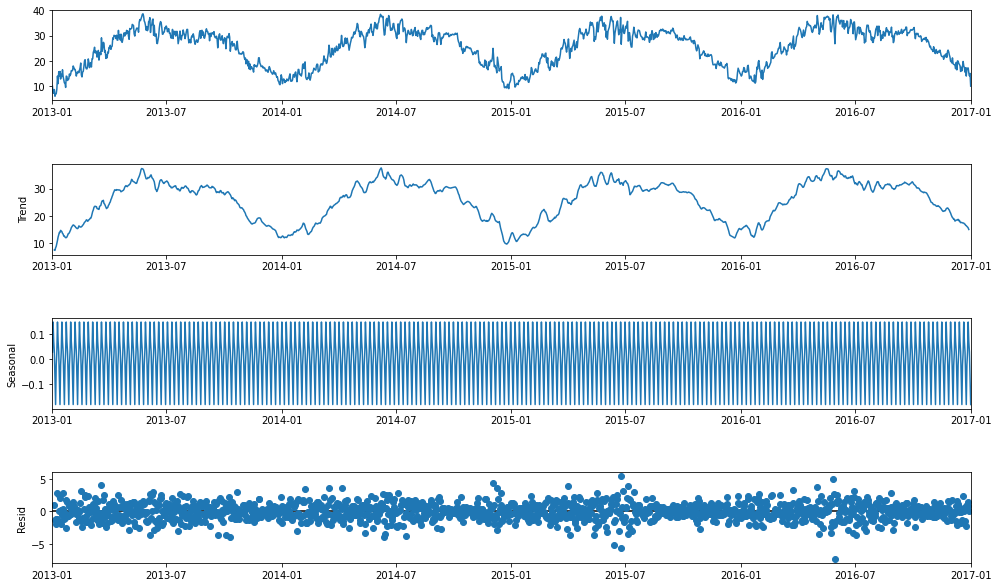

In [28]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

decomposition = sm.tsa.seasonal_decompose(df)
fig = decomposition.plot()
fig.set_size_inches(16,9)
fig.savefig('../Images/decomposition_plot.png')
plt.show()

we can say our data has huge seasonality and our trend may be uptrend and downtrend sometimes.  

### **Check Stationarity**  
Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.  

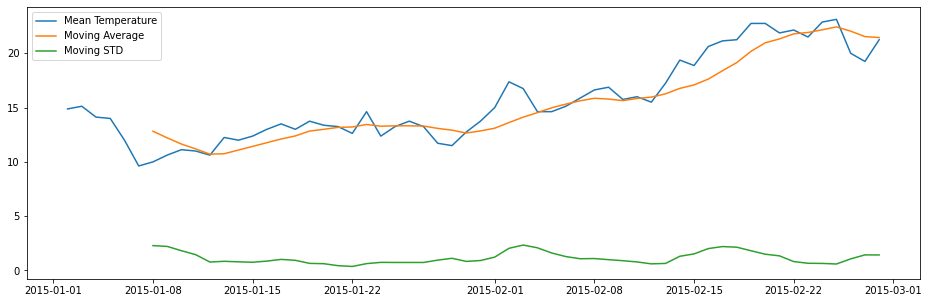

In [29]:
sample = df[(df.index > '2015-01-01')&(df.index < '2015-03-01')]

rolling_window = 7
moving_average = sample['meantemp'].rolling(window=7).mean()
moving_std = sample['meantemp'].rolling(window=7).std()

%matplotlib inline

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sample['meantemp'], label= 'Mean Temperature')
ax.plot(moving_average, label='Moving Average')
ax.plot(moving_std, label='Moving STD')
ax.legend(loc='upper left')

fig.savefig('../Images/plot_ma_mstd_meantemp.png')
plt.show()

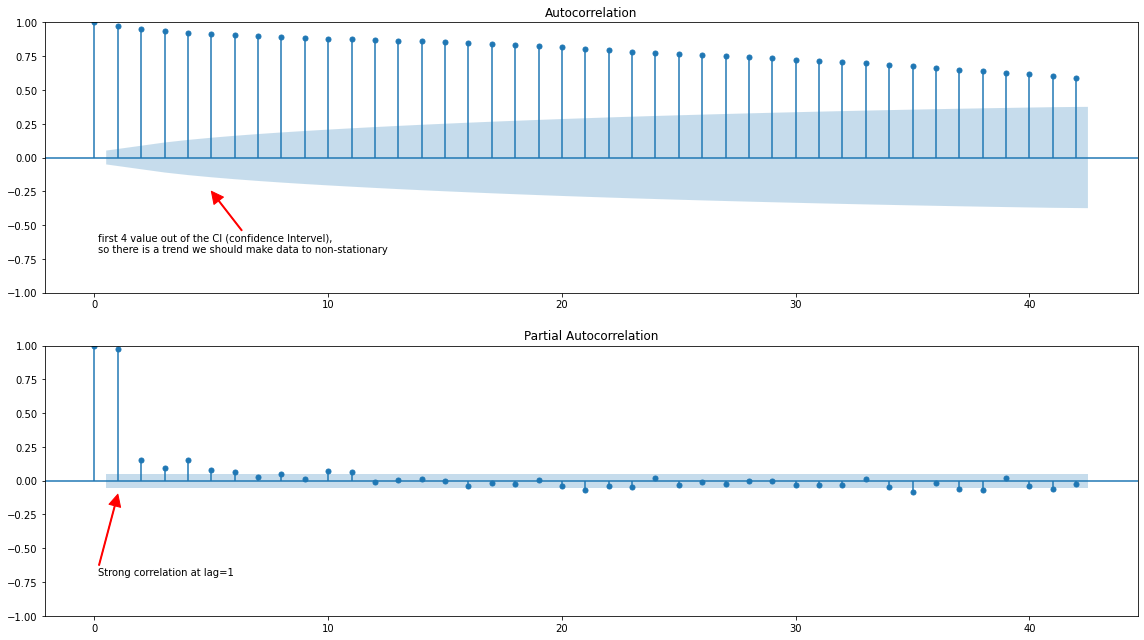

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))

plot_acf(df['meantemp'], lags=42, ax=ax[0])
plot_pacf(df['meantemp'], lags=42, ax=ax[1], method='ols')

decision = '''first 4 value out of the CI (confidence Intervel), 
so there is a trend we should make data to non-stationary'''

ax[0].annotate(decision, xy=(5, -0.25),
            xytext=(0.17, -0.7), arrowprops=dict(color='red', width=1))
ax[1].annotate('Strong correlation at lag=1', xy=(1, -0.1),
            xytext=(0.17, -0.7), arrowprops=dict(color='red', width=1))

plt.tight_layout(h_pad=2)
plt.show()

In [31]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(df, 'Raw Data')

 > Is the Raw Data stationary ?
Test statistic = -2.021
P-value = 0.277
Critical values :
	1%: -3.4348647527922824 - The data is not stationary with 99% confidence
	5%: -2.863533960720434 - The data is not stationary with 95% confidence
	10%: -2.567831568508802 - The data is not stationary with 90% confidence


$H_{0}:$ Data's stationary = 0 (Data is not stationary).  
$H_{1}:$ Data's stationary $\neq$ 0 (Data is stationary).  

We can't reject the null hypothesis.  

Looking at both the visualization and ADF test, we can tell that our sample data is non-stationary. Our purpose make data to stationary.

### De-Trending  
This method removes the underlying trend in the time series:

In [32]:
y = df['meantemp']
detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()
detrend.fillna(0, inplace=True)

ADF_test(detrend, 'De-Trended Data')

 > Is the De-Trended Data stationary ?
Test statistic = -16.916
P-value = 0.000
Critical values :
	1%: -3.434846127900848 - The data is  stationary with 99% confidence
	5%: -2.8635257411342616 - The data is  stationary with 95% confidence
	10%: -2.5678271914441395 - The data is  stationary with 90% confidence


$H_{0}:$ Data's stationary = 0 (Data is not stationary).  
$H_{1}:$ Data's stationary $\neq$ 0 (Data is stationary).  

We can reject the null hypothesis.  

Our time series de-trended with this formula:  
$$
y - y_{moving.average} \over y_{moving.devision}
$$

### Result  
We set our data to stationary so we can use our series to train our model and doing some predictions.  
  
If you want to next step you can keep reading with `predictions.ipynb` notebook.

In [35]:
detrend = pd.DataFrame(detrend)
detrend.reset_index(inplace=True)
detrend.columns = ['ds', 'y']
detrend.to_csv('../Datasets/detrend_train.csv', index=False)